# MIP Simulation

Here we calculate the sound created by minimum ionizing particles by using PyPhonon.

In [1]:
# Import libraries
from pyphonon import *
import matplotlib.pyplot as plt
from scipy.signal import chirp, find_peaks, peak_widths

# Check for GPU support
try:
    import cupy as cp
    import numpy as np
    GPU = True
    print(bcolors.OKGREEN+'GPU Support Enabled'+bcolors.ENDC)
except ImportError:
    import numpy as np
    GPU = False
    print(bcolors.WARNING+'Cupy Not available in your system. No GPU Support'+bcolors.ENDC)

# Ignore large warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

CUDA GPU Acceleration is unavailable for your system : (
Cupy Not available in your system. No GPU Support


In [2]:
# Simulator parameters
max_order   = 1
n_cores     = 10
slow        = False

# Create estimator
E = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 1
Assembling the estimator using multiprocessing on 10 cores
Permuations created successfully
	Send the fast data to the pool
CUDA GPU Acceleration is unavailable for your system : (
CUDA GPU Acceleration is unavailable for your system : (
CUDA GPU Acceleration is unavailable for your system : (
	Fast: 0, 0 Done!
	Fast: 1, 0 Done!
	Fast: 1, 1 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/3 [00:00<?, ?it/s]

Estimator Generated Successfully


In [6]:
# Create some additional helper functions

# Get the fast particle waves as a function of R
def get_params(r:float,v:float,T = np.array([-1.,40.]),N_pts:int=500,GPU=GPU):
    g = 1/(v**2-1)**0.5
    T = T + v * r
    z = r/g
    if GPU: t = cp.linspace(*T,N_pts)
    else:
        t = np.linspace(*T,N_pts)
    
    return r,z,t,v

# Calculate the average peak and FWHM
def get_peak(p,t,rel_height:float=0.8):
    peaks,_ = find_peaks(abs(p))
    results = peak_widths(abs(p),peaks,rel_height=rel_height)
    if len(peaks) == 0:
        return 0,0

    # Calculate the average width
    avg_width   = np.mean(results[0])*(t[1]-t[0])
    peak        = np.max(p[peaks])

    return peak,avg_width

# For a range of distances find the maximum
def sweep_r(R=np.linspace(0.1,100,100),v=3.0,l=2e-5,GPU=GPU):
    # Empty array to store the maxima over all the R's
    maxima  = []
    FWHM    = []

    # For each radius
    for rr in tqdm(R,desc='Radius GPU: '+str(GPU),leave=False):
        r,z,t,v = get_params(rr,v)
        p = E(r,z,t,v,l)

        # Calculate the peaks and FWHM
        if GPU: peak, avg_width = get_peak(p.get(),t.get())
        else: peak, avg_width = get_peak(p,t)

        # Append them to the appropriate arrays
        maxima.append(peak)
        FWHM.append(avg_width)

    return maxima,FWHM    

In [4]:
# Calculate 
V = np.linspace(2,8,4)
R = np.linspace(0.1,100,100)

pressure_max = []
pressure_wid = []

# Now do this for a range of velocities
for v in tqdm(V,desc='Velocities'):
    MAX,WID = sweep_r(R,v)
    pressure_max.append(MAX)
    pressure_wid.append(WID)

Velocities:   0%|          | 0/4 [00:00<?, ?it/s]

Radius GPU: False:   0%|          | 0/100 [00:00<?, ?it/s]

Radius GPU: False:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

ValueError: setting an array element with a sequence.

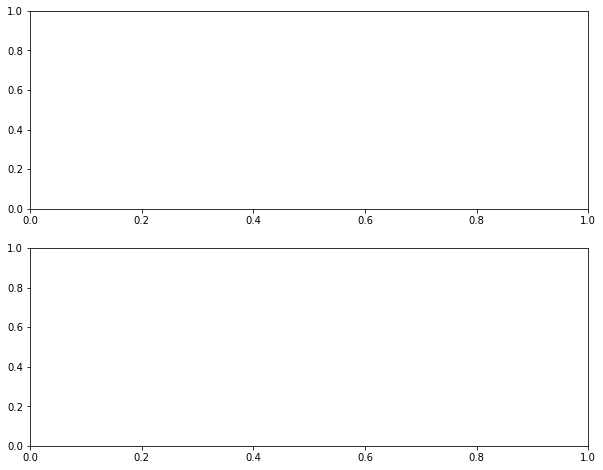

In [5]:
# Create a figure now
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot all the thingys
for v,pressure,width in zip(V,pressure_max,pressure_wid):
    ax1.plot(R,pressure,label=r'$v=%.1f$'%(v))
    ax2.plot(R,width,label=r'$v=%.1f$'%(v))

# Add a legend
ax1.legend(frameon=False)
ax1.set_yscale('log')
ax2.legend(frameon=False)
ax2.set_yscale('log')